## 09: Вспомогательные функции — загрузка, визуализация зависимости и Спирмен

Файл содержит:
- загрузку данных из БД;
- функцию визуализации зависимости признака от целевой `corrosion_rate`;
- функцию расчёта Спирмена для списка признаков.


In [3]:
# Импорты и загрузка данных
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if '../src' not in sys.path:
    sys.path.append('../src')
from database import load_corrosion_data

In [4]:
# Настройки
sns.set(style='whitegrid')
TARGET = 'corrosion_rate'

# Загрузка
DF = load_corrosion_data()
assert TARGET in DF.columns, 'В данных отсутствует corrosion_rate'

print(f"Данные: {len(DF):,} строк, {len(DF.columns)} колонок")
print('Колонки:')
print(sorted(DF.columns.tolist()))

Данные: 442,052 строк, 64 колонок
Колонки:
['acetic_acid_content', 'ammonia_content', 'ammonium_content', 'butane_content', 'butylene_content', 'chlorine_content', 'co2_content', 'component', 'component_type_id', 'component_type_name', 'contour', 'corrosion_inhibitor_content', 'corrosion_rate', 'cross_sectional_area', 'diameter_to_thickness_ratio', 'diesel_content', 'equipment', 'ethane_content', 'ethylene_content', 'gasoline_c6_c8_content', 'h2s_content', 'heavy_naphtha_content', 'hexane_content', 'hydrochloric_acid_content', 'hydrogen_content', 'hydrogen_fluoride_content', 'id', 'inner_diameter', 'installation', 'is_replaced', 'isobutane_content', 'isopentane_content', 'kerosene_content', 'material_code', 'material_resistance_score', 'material_type', 'measurement', 'measurement_date', 'methane_content', 'mms', 'naphthenic_acid_content', 'nitrogen_content', 'nominal_thickness_mmc', 'operating_pressure', 'operating_temperature', 'outer_diameter', 'oxygen_content', 'pentane_content', 'p

In [5]:
# Функция визуализации зависимости признака от цели

def plot_dependency(df: pd.DataFrame, feature: str, target: str = TARGET,
                    installation: str | None = None,
                    bins: int = 30, scatter_alpha: float = 0.2,
                    figsize: tuple = (8, 5)) -> None:
    """
    Визуализация зависимости признака feature от цели target.
    - Если указана installation, фильтрует по ней.
    - Рисует облако точек (scatter) + усреднение по бинам feature.
    """
    if feature not in df.columns:
        raise ValueError(f"Колонка '{feature}' отсутствует в данных")
    if target not in df.columns:
        raise ValueError(f"Колонка '{target}' отсутствует в данных")

    data = df.copy()
    if installation is not None and 'installation' in data.columns:
        data = data[data['installation'].astype(str) == str(installation)]

    x = pd.to_numeric(data[feature], errors='coerce')
    y = pd.to_numeric(data[target], errors='coerce')
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    if len(x) == 0:
        print('Нет данных для визуализации после фильтрации')
        return

    plt.figure(figsize=figsize)
    plt.scatter(x, y, s=8, alpha=scatter_alpha, color='tab:blue', label='наблюдения')

    # Линия усреднения по бинам
    try:
        bins_edges = np.linspace(x.min(), x.max(), bins + 1)
        cats = pd.cut(x, bins=bins_edges, include_lowest=True)
        by_bin = y.groupby(cats).mean()
        centers = [iv.left + (iv.right - iv.left) / 2 for iv in by_bin.index.categories]
        plt.plot(centers, by_bin.values, color='tab:red', lw=2, label='среднее по бинам')
    except Exception as e:
        print('Предупреждение (бинning):', e)

    title = f"{feature} vs {target}"
    if installation is not None:
        title += f" | installation={installation}"
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
# Функция: Спирмен по списку признаков

def spearman_for_features(df: pd.DataFrame, features: list, target: str = TARGET,
                          installation: str | None = None, top_k: int | None = None) -> pd.DataFrame:
    """
    Вычисляет коэффициент Спирмена признаков из списка с целевой переменной.
    Сортирует по |corr| убыв.
    """
    if target not in df.columns:
        raise ValueError(f"Целевая колонка '{target}' отсутствует")
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError('features должен быть непустым списком колонок')

    data = df.copy()
    if installation is not None and 'installation' in data.columns:
        data = data[data['installation'].astype(str) == str(installation)]

    num_df = data.select_dtypes(include=[np.number]).copy()
    feats = [f for f in features if f in num_df.columns and f != target]
    if len(feats) == 0:
        raise ValueError('Нет числовых признаков из переданного списка')

    valid = num_df[target].notna()
    num_df = num_df.loc[valid]

    corr = num_df[feats].rank().corrwith(num_df[target].rank())
    res = corr.dropna().sort_values(key=lambda s: s.abs(), ascending=False)
    if top_k:
        res = res.head(top_k)

    out = pd.DataFrame({'feature': res.index, 'spearman_corr': res.values})
    print(out.to_string(index=False))
    return out


In [11]:
# Фильтрация по конкретной установке
INSTALLATION_FILTER = 'KK-2'
df_kk_1 = DF[DF['installation'] == INSTALLATION_FILTER]

print(f"После фильтрации по '{INSTALLATION_FILTER}': {len(df_kk_1):,} строк")

После фильтрации по 'KK-2': 75,510 строк


C:\Users\admin\AppData\Local\Temp\ipykernel_8580\1067069831.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_bin = y.groupby(cats).mean()


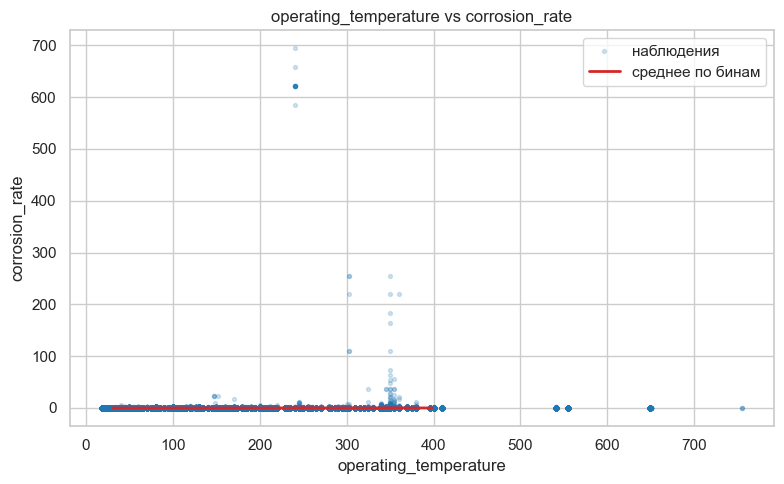

              feature  spearman_corr
          h2s_content       0.068771
operating_temperature       0.053996
          co2_content       0.007567


,feature,spearman_corr
0,h2s_content,0.068771
1,operating_temperature,0.053996
2,co2_content,0.007567


In [19]:
# Примеры вызова (раскомментируйте)
plot_dependency(DF, 'operating_temperature', TARGET, installation=None)
spearman_for_features(DF, ['h2s_content','co2_content','operating_temperature'], TARGET, installation=None, top_k=None)
